In [1]:
import os
import sys

path = os.getcwd()
while os.path.basename(os.path.normpath(path)) != 'roman-pandeia':
    path = os.path.dirname(path)
repo_path = path
if repo_path not in sys.path:
    sys.path.append(repo_path)

In [2]:
import numpy as np
import time
import pickle
from pprint import pprint
from tqdm import tqdm
import matplotlib.pyplot as plt
from pandeia.engine.perform_calculation import perform_calculation
from pandeia.engine.calc_utils import build_default_calc, build_default_source
from lenstronomy.Util import data_util
from lenstronomy.SimulationAPI.ObservationConfig.Roman import Roman
from hydra import initialize, compose
from pyHalo.Cosmology.cosmology import Cosmology

from package.lenses import sample_skypy_lens
from package.helpers import pandeia_input, pyhalo
from package.plots import diagnostic_plot, plot

plt.style.use(f'{repo_path}/package/mplstyle/science.mplstyle')

In [3]:
with initialize(version_base=None, config_path='../../config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, pickle_dir, repo_dir = config.machine.array_dir, config.machine.data_dir, config.machine.pickle_dir, config.machine.repo_dir

figure_dir = os.path.join(repo_dir, 'figures')
array_dir = os.path.join(array_dir, 'sample_skypy_lens')
pickle_dir = os.path.join(pickle_dir, 'pyhalo')

csv = os.path.join(repo_dir, 'data', 'roman_spacecraft_and_instrument_parameters.csv')

In [5]:
lens = sample_skypy_lens.SampleSkyPyLens()

num_pix = 51
side = 5.61
grid_oversample = 5
band = 'f106'

model = lens.get_array(num_pix=num_pix * grid_oversample, side=side)

In [6]:
# add CDM subhalos; NB same subhalo population for all
with open(os.path.join(pickle_dir, 'cdm_subhalos_for_sample_skypy_lens'), 'rb') as results_file:
    realizationCDM = pickle.load(results_file)

cosmo = Cosmology()
print(cosmo.astropy)

lens.add_subhalos(*pyhalo.realization_to_lensing_quantities(realizationCDM))

FlatLambdaCDM(H0=67.5 km / (Mpc s), Om0=0.309, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=0.049)


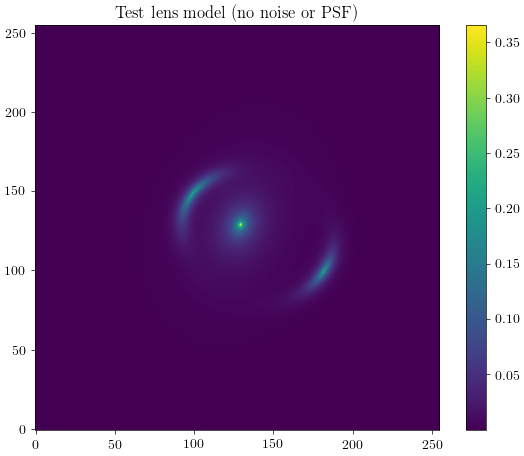

In [7]:
plot.plot(array=model,
          colorbar=True,
          title='Test lens model (no noise or PSF)')

In [8]:
num_samples = 10000

# build Pandeia input
calc, num_point_sources = pandeia_input.build_pandeia_calc(csv=csv,
                                        array=model, 
                                        lens=lens, 
                                        band='f106', 
                                        num_samples=num_samples)

100%|██████████| 5893/5893 [00:39<00:00, 150.70it/s]

Point source conversion complete: placed 5893 point sources
Estimated calculation time: 0:07:43


In [9]:
# turn background off. options include 'none', 'minzodi' (default), and 'ecliptic'
calc['background'] = 'none'

# turn all noise and effects off
calculation_dict = pandeia_input.get_calculation_dict(init=False)
calc['calculation'] = calculation_dict

In [10]:
# do Pandeia calculation        
detector, execution_time = pandeia_input.get_pandeia_image(calc)
print(f'Execution time: {execution_time}')

np.save(os.path.join(array_dir, f'no_noise_or_background_{grid_oversample}_{num_samples}'), detector)

Performing Pandeia calculation...
Pandeia calculation complete in 0:09:06
Execution time: 0:09:06


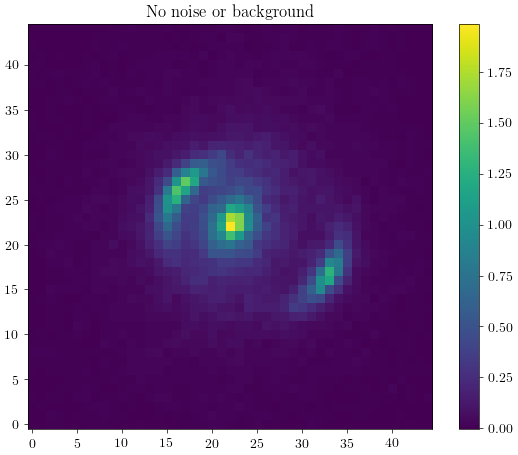

In [11]:
plot.plot(array=detector,
          colorbar=True,
          title='No noise or background')